Installing Libraries

In [ ]:
!pip install fasttext
!pip install numpy==1.24.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313506 sha256=b86026a38633194a4bce5656ef95ee8657dba187c10618799aab6910dd2e1b60
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

Importing Libraries

In [ ]:
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the FastText wrapper for FastText Model
class FastTextWrapper:
    def __init__(self, bin_path):
        self.model = fasttext.load_model(bin_path)

    def predict_proba(self, texts):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        elif isinstance(texts, str):
            texts = [texts]

        # Get predictions
        labels_list, probs_list = self.model.predict(texts, k=1)  # only top guess
        output = []
        for labels, probs in zip(labels_list, probs_list):
            p = probs[0]
            if labels[0] == "__label__spam":
                output.append([1 - p, p])  # ham, spam
            else:
                output.append([p, 1 - p])
        return np.array(output)

# Load model
fasttext_model = FastTextWrapper('/content/drive/MyDrive/Colab Notebooks/SmsSpamProject/spam_fasttext_model.bin')

FastText Model

In [ ]:
# Unsupervised training for other models
ft_model = fasttext.train_unsupervised("corpus.txt", model='skipgram')
def get_sentence_vector(text):
    return ft_model.get_sentence_vector(text)

Random Forest

In [ ]:
def word_level_shap(text, model, vectorizer):
    words = text.split()
    base_vector = vectorizer(text).reshape(1, -1)
    base_pred = model.predict_proba(base_vector)[0][1]

    word_importance = []
    for i, word in enumerate(words):
        modified_text = ' '.join(words[:i] + words[i+1:])
        modified_vector = vectorizer(modified_text).reshape(1, -1)
        modified_pred = model.predict_proba(modified_vector)[0][1]
        importance = round(base_pred - modified_pred, 5)
        word_importance.append((word, importance))

    return sorted(word_importance, key=lambda x: -abs(x[1]))


def word_level_shap_fasttext(text, model):
    words = text.split()
    base_pred = model.predict_proba([text])[0][1]  # fastText expects list of texts

    masker = shap.maskers.Text()

    # Define a prediction function compatible with SHAP that takes a list of texts
    def f(texts):
        return model.predict_proba(texts)

    explainer = shap.Explainer(f, masker, output_names=['ham', 'spam'], link=shap.links.identity, algorithm="partition")

    shap_values = explainer([text])

    # shap_values[0] contains explanation for first (and only) input text
    word_importances = dict(zip(words, shap_values[0].values))

    return word_importances


sms = "You have won 10000000 Rs. Claim you winning by clicking on this link now! www.winbig.com"

rf_model = joblib.load('rf_model.pkl')
word_importances_rf = word_level_shap(sms, rf_model, get_sentence_vector)
print(word_importances_rf)

lr_model = joblib.load('lr_model.pkl')
word_importances_lr = word_level_shap(sms, lr_model, get_sentence_vector)
print(word_importances_lr)

svm_model = joblib.load('svm_model.pkl')
word_importances_svm = word_level_shap(sms, svm_model, get_sentence_vector)
print(word_importances_svm)

xgb_model = joblib.load('xgb_model.pkl')
word_importances_xgb = word_level_shap(sms, xgb_model, get_sentence_vector)
print(word_importances_xgb)

word_importances_ft = word_level_shap_fasttext(sms, fasttext_model)  # identity, since model uses raw text

fasttext_shap_processed = [
    (word, round(float(vals[0] - vals[1]), 5))  # difference between class 0 and 1 shap values
    for word, vals in word_importances_ft.items()
]
print(fasttext_shap_processed)
proba_rf = rf_model.predict_proba([get_sentence_vector(sms)])
print(f"Spam probability: {proba_rf[0][1]}")
proba_rf = lr_model.predict_proba([get_sentence_vector(sms)])
print(f"Spam probability: {proba_rf[0][1]}")
proba_rf = xgb_model.predict_proba([get_sentence_vector(sms)])
print(f"Spam probability: {proba_rf[0][1]}")
proba_rf = svm_model.predict_proba([get_sentence_vector(sms)])
print(f"Spam probability: {proba_rf[0][1]}")
proba_rf = fasttext_model.predict_proba(sms)
print(f"Spam probability: {proba_rf[0][1]}")

[('Claim', 0.33333), ('you', -0.26667), ('on', -0.2), ('You', -0.13333), ('10000000', 0.13333), ('by', -0.13333), ('this', -0.13333), ('have', -0.06667), ('won', 0.06667), ('Rs.', -0.06667), ('winning', -0.06667), ('clicking', -0.06667), ('now!', 0.06667), ('link', 0.0), ('www.winbig.com', 0.0)]
[('Claim', 0.1152), ('10000000', 0.10766), ('won', 0.10672), ('you', -0.09211), ('clicking', -0.08998), ('this', -0.084), ('now!', 0.07945), ('winning', -0.06609), ('by', -0.05876), ('have', -0.05273), ('Rs.', 0.03362), ('www.winbig.com', 0.01794), ('on', -0.00958), ('You', 0.00464), ('link', -0.00181)]
[('Claim', 0.17253), ('10000000', 0.15804), ('won', 0.14162), ('now!', 0.13427), ('this', -0.07169), ('clicking', -0.0711), ('you', -0.06353), ('by', -0.05766), ('winning', -0.05668), ('have', -0.0532), ('Rs.', 0.02794), ('on', -0.02102), ('link', -0.01544), ('www.winbig.com', 0.01143), ('You', -0.00906)]
[('Claim', 0.50743), ('now!', 0.49587), ('10000000', 0.20244), ('www.winbig.com', 0.19808),

<ipython-input-8-2df3e1dc6258>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')


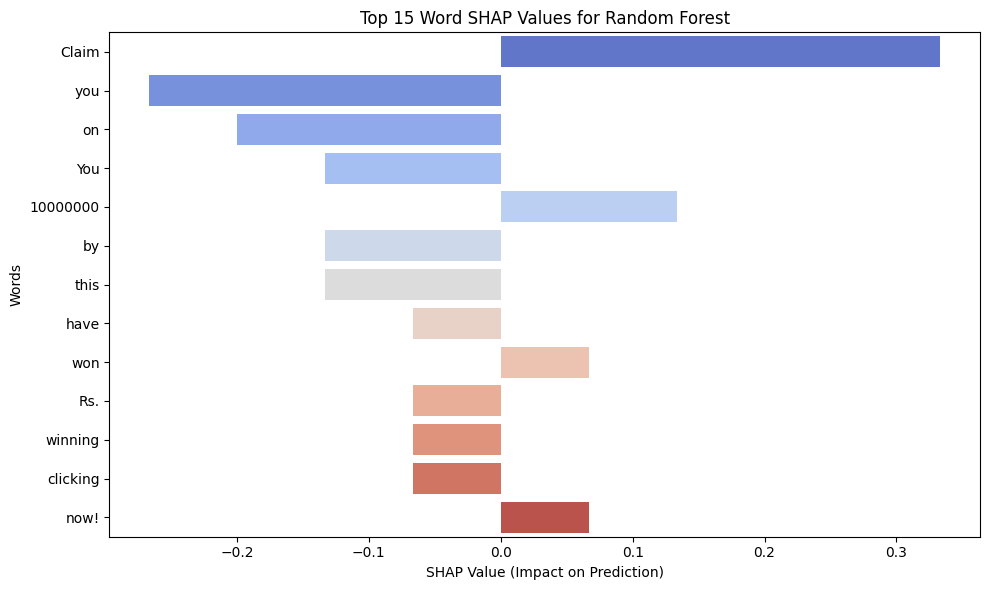

<ipython-input-8-2df3e1dc6258>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')


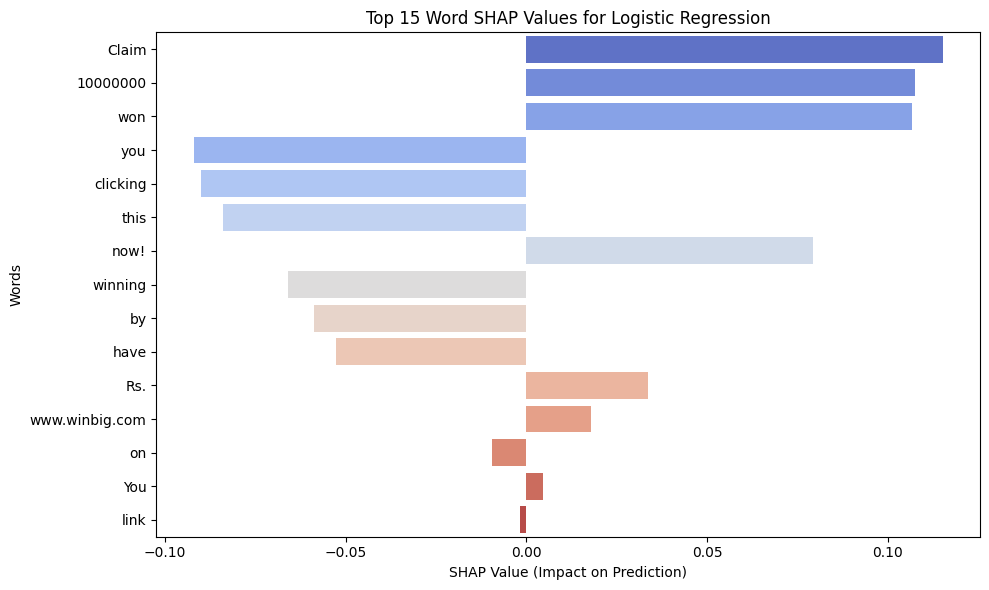

<ipython-input-8-2df3e1dc6258>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')


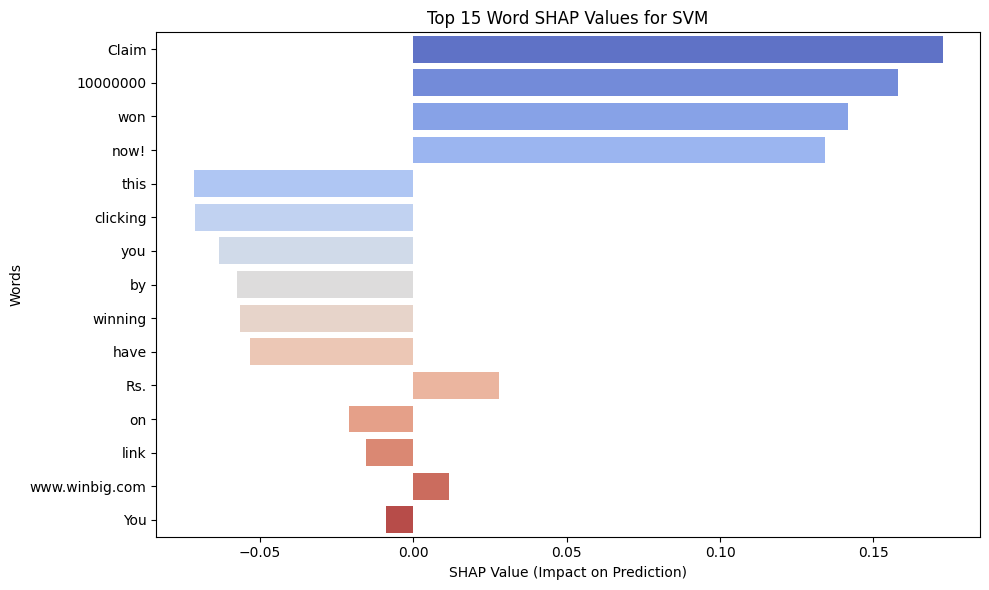

<ipython-input-8-2df3e1dc6258>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')


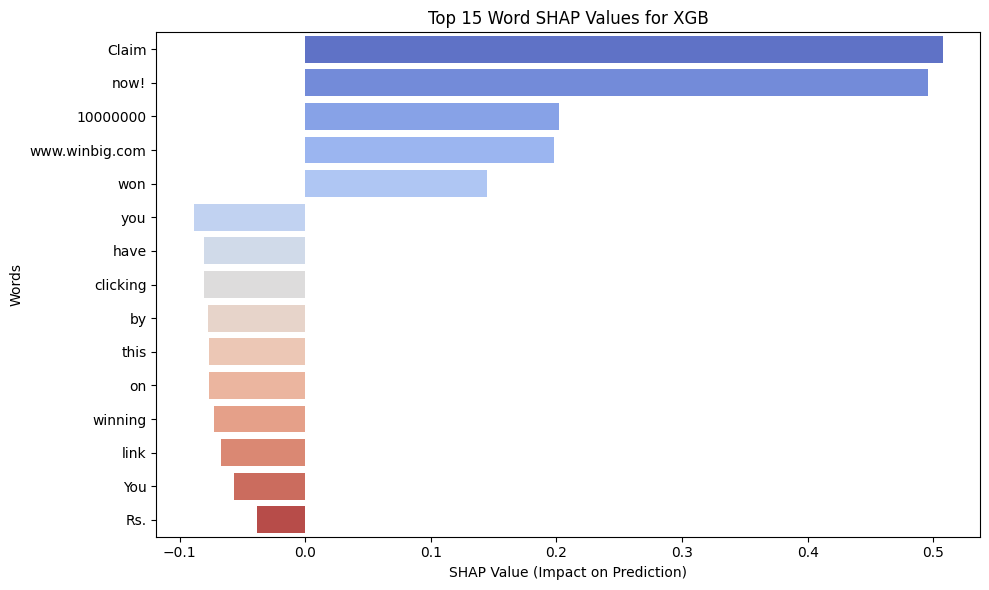

<ipython-input-8-2df3e1dc6258>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')


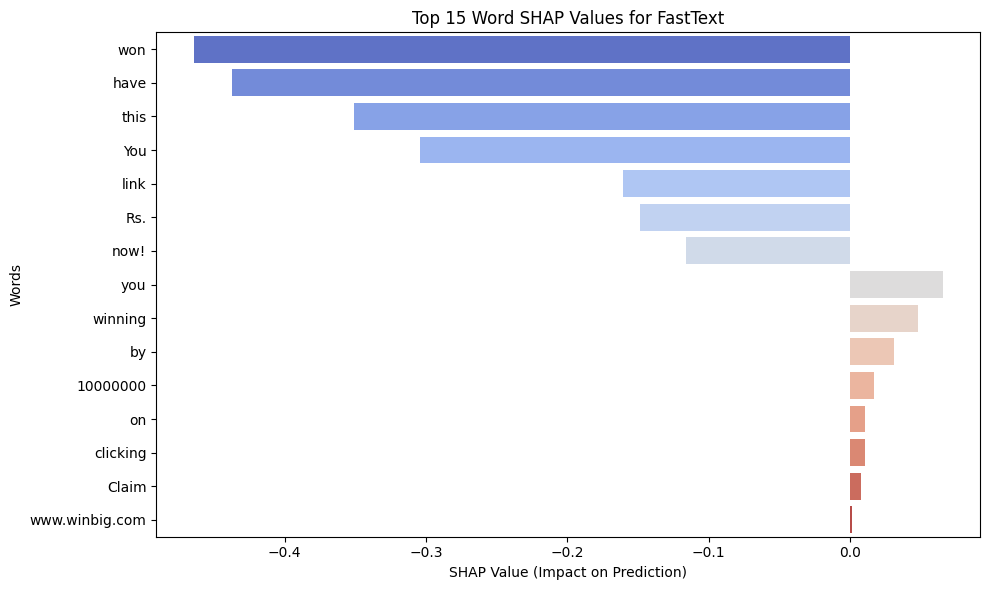

In [ ]:
def plot_shap_word_importances(shap_list, model_name, top_n=15):
    # Remove zero-importance words
    filtered = [t for t in shap_list if t[1] != 0]
    # Sort by absolute SHAP value descending
    sorted_words = sorted(filtered, key=lambda x: abs(x[1]), reverse=True)[:top_n]

    words, values = zip(*sorted_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(values), y=list(words), palette="coolwarm", orient='h')
    plt.title(f'Top {top_n} Word SHAP Values for {model_name}')
    plt.xlabel('SHAP Value (Impact on Prediction)')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

# Plot your RF model output
plot_shap_word_importances(word_importances_rf, "Random Forest")
plot_shap_word_importances(word_importances_lr, "Logistic Regression")
plot_shap_word_importances(word_importances_svm, "SVM")
plot_shap_word_importances(word_importances_xgb, "XGB")
plot_shap_word_importances(fasttext_shap_processed, "FastText")